## Übung zu Kapitel 9

Mit dieser Übung wollen wir unsere Kenntnisse der Zeitreihenanalyse vertiefen, indem wir die Methoden aus diesem Kapitel anwenden. Als Daten verwenden wir den [Umsatz von Online- und Versandshops von 2002 bis 2014 aus den USA](https://data-science-crashkurs.de/exercises/data/online_and_mail_shopping.csv). 

### Trend- und Saisonbereinigung

Laden Sie die Daten. Verwenden Sie sowohl die lineare Regression und saisonale Mittel als auch Differencing, um den Trend und die saisonalen Effekte zu bereinigen. Vergleichen Sie die Ergebnisse mithilfe von Visualisierungen.

Zuerst laden wir die Daten und visualisieren die unbereinigte Zeitreihe. 

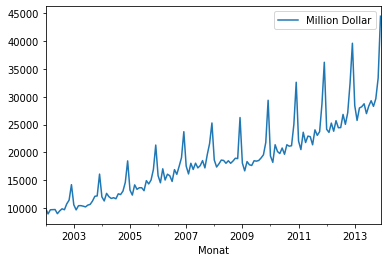

In [19]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression


revenue_df = pd.read_csv('data/online_and_mail_shopping.csv',
                        header = 0, parse_dates = [0], names = ['Month', 'mdollars'], index_col = 0)
revenue_df.plot()
plt.xlabel('Monat')
legend = plt.legend()
legend.get_texts()[0].set_text('Million Dollar')
plt.show()

Es sieht aus als gebe es einen etwa linearen Trend und ein saisonales Muster welches im Dezember am stärksten ausschlägt. Dies lässt sich durch die Feiertage erklären. Man sieht außerdem einen Abfall am Ende des Jahres 2008, welcher vermutlich mit der Finanzkrise zusammenhängt. In der Lösung erweitern wir jetzt die Daten um weitere Spalten mit den Zwischenergebnissen. 

Zuerst entfernen wir den Trend mit einer linearen Regression. 

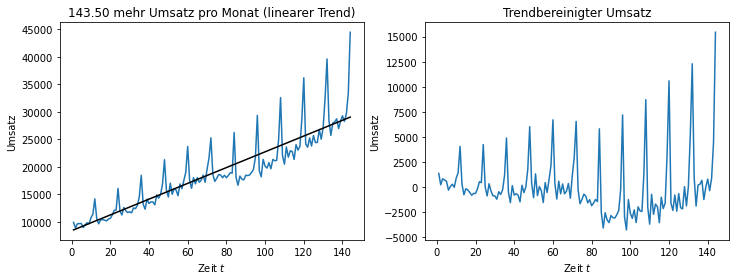

In [2]:
X = np.arange(1,revenue_df.shape[0]+1).reshape(-1, 1)
Y = revenue_df['mdollars'].values.reshape(-1, 1)

regr = LinearRegression()
ax = regr.fit(X, Y)
T_pred = regr.predict(X)[:,0]
revenue_df['mdollars_lin'] = revenue_df['mdollars']-T_pred

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('%.2f mehr Umsatz pro Monat (linearer Trend)' % regr.coef_[0])
axes[0].plot(X, Y)
axes[0].plot(X, T_pred, color='black')
axes[0].set_xlabel('Zeit $t$')
axes[0].set_ylabel('Umsatz')

axes[1].set_title('Trendbereinigter Umsatz')
axes[1].plot(X, revenue_df['mdollars_lin'])
axes[1].set_xlabel('Zeit $t$')
axes[1].set_ylabel('Umsatz')
plt.show()

Die Saisonalität scheint eine jährliche Periode zu haben. Daher berechnen wir jetzt die monatlichen Mittel um den saisonalen Effekt zu entfernen. 

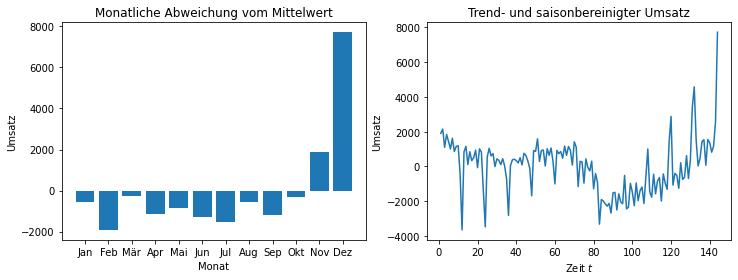

In [3]:
monthly_means = revenue_df['mdollars_lin'].groupby(revenue_df['mdollars_lin'].index.month).mean()

revenue_df['mdollars_lin_adj'] = revenue_df['mdollars_lin'] - np.tile(monthly_means,12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Monatliche Abweichung vom Mittelwert')
axes[0].bar(['Jan','Feb','Mär','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez'], monthly_means)
axes[0].set_xlabel('Monat')
axes[0].set_ylabel('Umsatz')

axes[1].set_title('Trend- und saisonbereinigter Umsatz')
axes[1].plot(X, revenue_df['mdollars_lin_adj'])
axes[1].set_xlabel('Zeit $t$')
axes[1].set_ylabel('Umsatz')
plt.show()

Wir sehen das gleiche Problem wie bereits vorher auch: Der saisonale Effekt wird mit dem Trend ebenfalls stärker und wird daher nicht vollständig korrigiert. Vor ca. $t=70$ ist die Bereinigung zu stark, anschließend zu schwach. Bei der Trendbereinigung sieht man, dass sich die monatlichen Umsätze um ca. 143 Millionen Dollar pro Monat erhöhen und dass der Umsatz im Dezember um ca. 8000 Million Doller höher als im Jahresmittel ist. 

Jetzt verwenden wir Differencing um den Trend zu entfernen. 

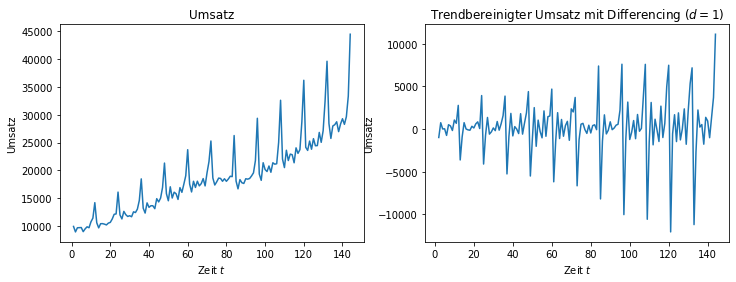

In [4]:
revenue_df['mdollars_diff'] = revenue_df['mdollars'].diff(1)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Umsatz')
axes[0].plot(X, Y)
axes[0].set_xlabel('Zeit $t$')
axes[0].set_ylabel('Umsatz')

axes[1].set_title('Trendbereinigter Umsatz mit Differencing ($d=1$)')
axes[1].plot(X, revenue_df['mdollars_diff'])
axes[1].set_xlabel('Zeit $t$')
axes[1].set_ylabel('Umsatz')
plt.show()

Der Trend scheint jetzt vollständig entfernt zu sein. Nun entfernen wir den saisonalen Effekt ebenfalls durch Differencing. 

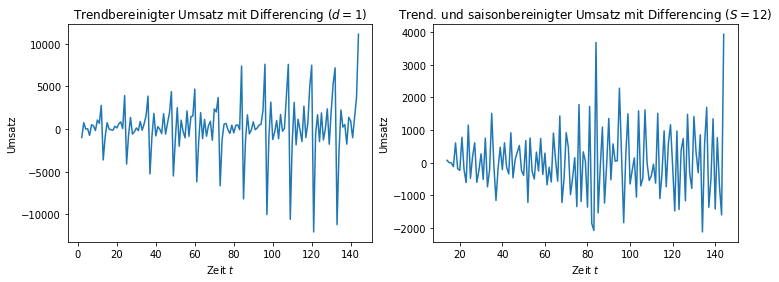

In [5]:
revenue_df['mdollars_diff_adj'] = revenue_df['mdollars_diff'].diff(periods=12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Trendbereinigter Umsatz mit Differencing ($d=1$)')
axes[0].plot(X, revenue_df['mdollars_diff'])
axes[0].set_xlabel('Zeit $t$')
axes[0].set_ylabel('Umsatz')

axes[1].set_title('Trend. und saisonbereinigter Umsatz mit Differencing ($S=12$)')
axes[1].plot(X, revenue_df['mdollars_diff_adj'])
axes[1].set_xlabel('Zeit $t$')
axes[1].set_ylabel('Umsatz')
plt.show()

Jetzt sehen die Daten stationär mit zufälliger Schwankung von etwa 2000 Millionen Dollar aus. 

### Vorhersagen mit ARMA

Trainieren Sie ein ARMA-Modell mit geeigneten Parametern für $p$ und $q$ für beide Varianten der trend- und saisonbereinigten Daten. Entfernen Sie für das Training die Daten aus dem Jahr 2013. Benutzen Sie anschließend die Modelle, um Werte für das Jahr 2013 vorherzusagen, und visualisieren Sie den Unterschied zwischen den Vorhersagen und den wahren Werten. Dieser Vergleich sollte nicht nur die autoregressive Komponente ($R_t$), sondern die echten Werte $x_t = T_t+S_t+R_t$ berücksichtigen. Hierzu müssen Sie die saisonalen Effekte und den Trend auf die Vorhersage aus dem ARMA-Modell addieren.

Zuerst betrachten wir die (partielle) Autokorrelation. 

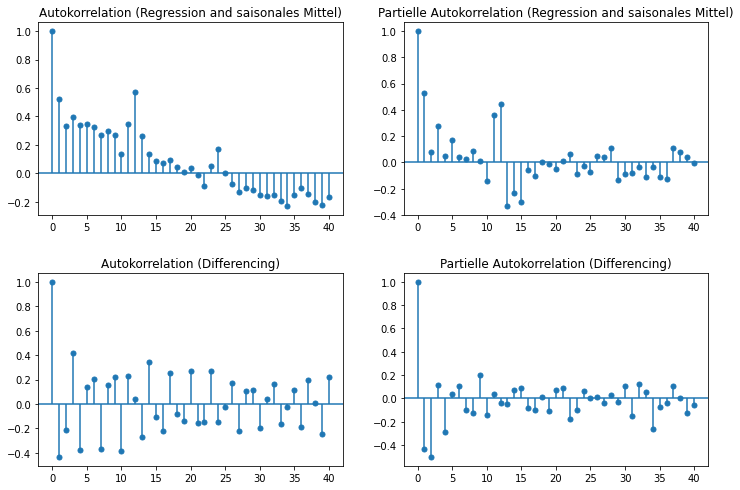

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

plot_acf(revenue_df['mdollars_lin_adj'], lags=40, alpha=None, ax=axes[0,0], title="Autokorrelation (Regression and saisonales Mittel)")
plot_pacf(revenue_df['mdollars_lin_adj'], lags=40, alpha=None, ax=axes[0,1], title="Partielle Autokorrelation (Regression and saisonales Mittel)")
plot_acf(revenue_df['mdollars_diff_adj'].dropna(), lags=40, alpha=None, ax=axes[1,0], title="Autokorrelation (Differencing)")
plot_pacf(revenue_df['mdollars_diff_adj'].dropna(), lags=40, alpha=None, ax=axes[1,1], title="Partielle Autokorrelation (Differencing)")
plt.subplots_adjust(left=None, bottom=0, right=None,
                top=None, wspace=None, hspace=0.3)
plt.show()

Für Regression mit saisonalen Mittel wählen wir $p=15$, da es hier einen direkten Zusammenhang gibt, den man insbesondere in der partiellen Autokorrelation gut erkennt. Auch wenn das Model damit sehr groß ist, sollte es in der Lage sein den nicht korrigierten saisonalen Effekt zu erfassen. Auch wenn die Autokorrelation erst nach ca. 12 Zeitschritten gegen null tendiert, sieht es so aus als ob sich das durch den direkten Zusammenhang zwischen den Zeitpunkten bereits erklären lässt. Daher wählen wir $q=1$. 

Für das Differencing wählen wir $p=2$, da anschließend nur noch schwache partielle Autokorrelationen sichtbar sind. Da die Autokorrelation ein ähnliches Muster wie die partielle Autokorrelation hat, gehen wir davon aus, dass die Autokorrelation sich großteils durch die partielle Autokorrelation erklären lässt. Daher wählen wir ebenfalls $q=1$. 

Jetzt können wir ARMA Modelle für diese Parameter trainieren und anschließend die nächsten zwölf Monate vorhersagen. Hierzu müssen wir im Anschluss an die Vorhersage des ARMA Modells noch den Trend und die Saison wieder hinzufügen. Hier sind die Ergebnisse für die Regression und das saisonale Mittel. 

/home/sherbold/git/data-science-crashkurs/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


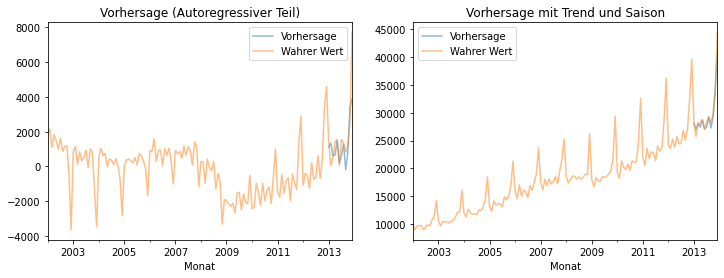

In [16]:
Y_train = revenue_df[revenue_df.index.year != 2013]['mdollars_lin_adj'].values

model = ARIMA(Y_train, order=(15,0,1))
model_fit = model.fit()

y_pred = model_fit.forecast(steps=12)

# we must not forget to add the trend and the seasonal effect
y_pred_lin_adj = y_pred+T_pred[revenue_df.index.get_loc('2013-01-01'):]+monthly_means.values

revenue_df['mdollars_lin_pred_arma'] = np.NaN
revenue_df['mdollars_lin_pred_total'] = np.NaN
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_lin_pred_arma'] = y_pred
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_lin_pred_total'] = y_pred_lin_adj

fig, axes = plt.subplots(1,2,figsize=(12,4))
revenue_df[['mdollars_lin_pred_arma', 'mdollars_lin_adj']].plot(alpha=0.5, title='Vorhersage (Autoregressiver Teil)', ax=axes[0])
revenue_df[['mdollars_lin_pred_total', 'mdollars']].plot(alpha=0.5, title='Vorhersage mit Trend und Saison', ax=axes[1])
axes[0].set_xlabel('Monat')
axes[1].set_xlabel('Monat')
legend = axes[0].legend()
legend.get_texts()[0].set_text('Vorhersage')
legend.get_texts()[1].set_text('Wahrer Wert')
legend = axes[1].legend()
legend.get_texts()[0].set_text('Vorhersage')
legend.get_texts()[1].set_text('Wahrer Wert')
plt.show()

Auch wenn die Zeitreihe nicht vollständig stationär war, kriegen wir dennoch eine gute Vorhersage, die ähnlich zu den wahren Werten ist. 

Nun das Modell für das Differencing. 

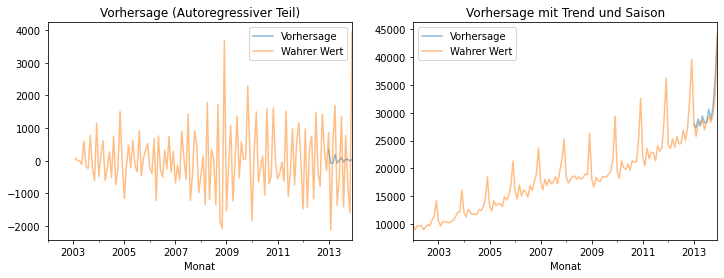

In [17]:
Y_train = revenue_df[revenue_df.index.year != 2013]['mdollars_diff_adj'].dropna().values

model = ARIMA(Y_train, order=(2,0,1))
model_fit = model.fit()

y_pred = model_fit.forecast(steps=12)

y_pred_diff_adj = y_pred.copy()
# add season -> add values prior to seasonal adjustment
for i in range(0, 12):
    y_pred_diff_adj[i] += revenue_df.iloc[-24+i]['mdollars_diff'] # add value from last year of with seasonal effect
# add trend -> add values prior to differencing for trend
y_pred_diff_adj[0] += revenue_df.iloc[-13]['mdollars']
for i in range(1,12):
    y_pred_diff_adj[i] += y_pred_diff_adj[i-1]


revenue_df['mdollars_diff_pred_arma'] = np.NaN
revenue_df['mdollars_diff_pred_total'] = np.NaN
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_diff_pred_arma'] = y_pred
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_diff_pred_total'] = y_pred_diff_adj

fig, axes = plt.subplots(1,2,figsize=(12,4))
revenue_df[['mdollars_diff_pred_arma', 'mdollars_diff_adj']].plot(alpha=0.5, title='Vorhersage (Autoregressiver Teil)', ax=axes[0])
revenue_df[['mdollars_diff_pred_total', 'mdollars']].plot(alpha=0.5, title='Vorhersage mit Trend und Saison', ax=axes[1])
axes[0].set_xlabel('Monat')
axes[1].set_xlabel('Monat')
legend = axes[0].legend()
legend.get_texts()[0].set_text('Vorhersage')
legend.get_texts()[1].set_text('Wahrer Wert')
legend = axes[1].legend()
legend.get_texts()[0].set_text('Vorhersage')
legend.get_texts()[1].set_text('Wahrer Wert')
plt.show()

Das Ergebnis sieht sogar noch etwas besser aus. Dies sieht man auch, wenn man die Ergebnisse direkt miteinander vergleicht. 

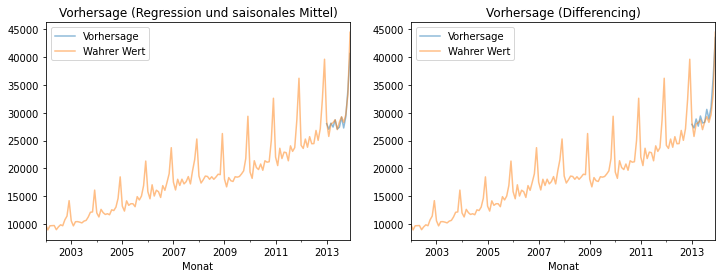

In [18]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
revenue_df[['mdollars_lin_pred_total', 'mdollars']].plot(alpha=0.5, title='Vorhersage (Regression und saisonales Mittel)', ax=axes[0])
revenue_df[['mdollars_diff_pred_total', 'mdollars']].plot(alpha=0.5, title='Vorhersage (Differencing)', ax=axes[1])
axes[0].set_xlabel('Monat')
axes[1].set_xlabel('Monat')
legend = axes[0].legend()
legend.get_texts()[0].set_text('Vorhersage')
legend.get_texts()[1].set_text('Wahrer Wert')
legend = axes[1].legend()
legend.get_texts()[0].set_text('Vorhersage')
legend.get_texts()[1].set_text('Wahrer Wert')
plt.show()

Der größte Unterschied ist im Dezember, was man im Plot nur sehr schwer sieht. Hier unterschätzt die Vorhersage mit der Regression und dem saisonalen Mittel den Wert. Dies sieht man besser, wenn man sich direkt die Ergebnisse ansieht. 

In [10]:
revenue_df[['mdollars', 'mdollars_lin_pred_total', 'mdollars_diff_pred_total']][-12:]

,mdollars,mdollars_lin_pred_total,mdollars_diff_pred_total
Month,,,
2013-01-01,28437,28049.637894,27924.504925
2013-02-01,25749,27056.057767,27276.201887
2013-03-01,27988,28130.332252,28883.876928
2013-04-01,28218,27440.195322,27602.868262
2013-05-01,28748,28712.271540,29426.336193
2013-06-01,26975,27094.906202,28171.737761
2013-07-01,28349,27413.393958,28289.373121
2013-08-01,29297,29215.557279,30618.016363
2013-09-01,28283,27268.789193,28878.471840


Der Grund hierfür ist, dass der saisonale Effekt für die späteren Zeitpunkte nicht vollständig korrigiert wird, was hier zum Unterschätzen führt. 